algorithm        Bad O(n^2)   Heap  Merge  Quick (median3)  Quick (random)
input_kind n                                                              
few_unique 100        0.122  0.047  0.054            0.084           0.079
           500        3.834  0.316  0.325            1.272           1.254
           1500      38.947  1.179  1.108           10.172          10.034
random     100        0.143  0.058  0.058            0.040           0.047
           500        4.178  0.390  0.353            0.276           0.295
           1500      43.342  1.449  1.237            0.950           1.022
reversed   100        0.192  0.050  0.045            0.040           0.045
           500        5.375  0.348  0.254            0.316           0.294
           1500      54.791  1.317  0.863            1.177           0.978
sorted     100        0.002  0.058  0.043            0.038           0.042
           500        0.011  0.410  0.256            0.208           0.271
           1500       0.0

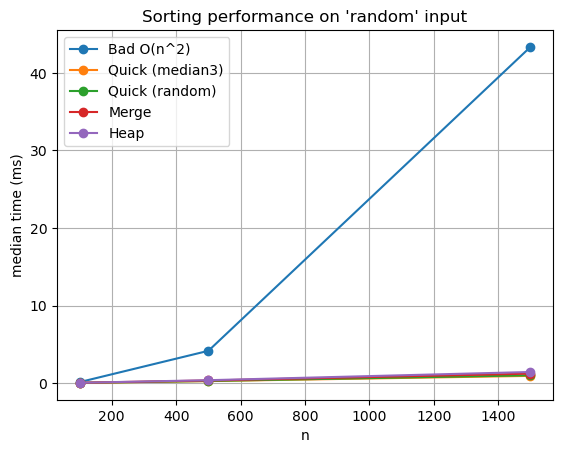

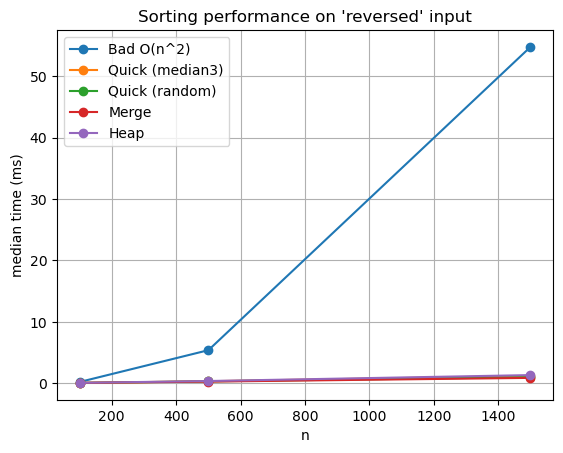

In [18]:


import random, time, statistics as st
from typing import List, Callable, Dict
import pandas as pd
import matplotlib.pyplot as plt

def bad_sort(arr: List[int]) -> List[int]:
    a = arr[:]; n = len(a)
    for i in range(n):
        swapped = False
        for j in range(0, n - i - 1):
            if a[j] > a[j + 1]:
                a[j], a[j + 1] = a[j + 1], a[j]; swapped = True
        if not swapped: break
    return a

def quick_sort(arr: List[int], pivot_mode: str = "median3") -> List[int]:
    a = arr[:]
    def choose_pivot(lo:int,hi:int)->int:
        if pivot_mode=="random": return random.randint(lo,hi)
        mid=(lo+hi)//2; trio=[(a[lo],lo),(a[mid],mid),(a[hi],hi)]; trio.sort(key=lambda t:t[0]); return trio[1][1]
    def partition(lo:int,hi:int)->int:
        p=choose_pivot(lo,hi); a[p],a[hi]=a[hi],a[p]; pivot=a[hi]; i=lo
        for j in range(lo,hi):
            if a[j] <= pivot: a[i],a[j]=a[j],a[i]; i+=1
        a[i],a[hi]=a[hi],a[i]; return i
    def qsort(lo:int,hi:int)->None:
        while lo<hi:
            p=partition(lo,hi)
            if (p-1)-lo < hi-(p+1):
                if lo<p-1: qsort(lo,p-1)
                lo=p+1
            else:
                if p+1<hi: qsort(p+1,hi)
                hi=p-1
    if len(a)>1: qsort(0,len(a)-1)
    return a

def merge_sort(arr: List[int]) -> List[int]:
    a = arr[:]
    if len(a)<=1: return a
    mid=len(a)//2
    L=merge_sort(a[:mid]); R=merge_sort(a[mid:])
    i=j=0; out=[]
    while i<len(L) and j<len(R):
        if L[i] <= R[j]: out.append(L[i]); i+=1
        else: out.append(R[j]); j+=1
    if i<len(L): out.extend(L[i:])
    if j<len(R): out.extend(R[j:])
    return out

def heap_sort(arr: List[int]) -> List[int]:
    a = arr[:]; n=len(a)
    def sift_down(i:int,size:int):
        while True:
            m=i; l=2*i+1; r=2*i+2
            if l<size and a[l]>a[m]: m=l
            if r<size and a[r]>a[m]: m=r
            if m==i: return
            a[i],a[m]=a[m],a[i]; i=m
    for i in range(n//2-1,-1,-1): sift_down(i,n)
    for end in range(n-1,0,-1):
        a[0],a[end]=a[end],a[0]; sift_down(0,end)
    return a

#Benchmark harness
Algos: Dict[str, Callable[[List[int]], List[int]]] = {
    "Bad O(n^2)": bad_sort,
    "Quick (median3)": lambda a: quick_sort(a, "median3"),
    "Quick (random)": lambda a: quick_sort(a, "random"),
    "Merge": merge_sort,
    "Heap": heap_sort,
}

def make_dataset(kind: str, n: int) -> List[int]:
    if kind == "random":   return [random.randint(0,10_000) for _ in range(n)]
    if kind == "sorted":   return list(range(n))
    if kind == "reversed": return list(range(n))[::-1]
    if kind == "few_unique":
        vals=[0,1,2,3,4]; return [random.choice(vals) for _ in range(n)]
    raise ValueError("unknown kind")

def time_once(fn: Callable[[List[int]], List[int]], data: List[int]) -> float:
    t0=time.perf_counter(); _=fn(data.copy()); return time.perf_counter()-t0

def benchmark_suite(
    sizes=(100, 500, 1500),
    kinds=("random","sorted","reversed","few_unique"),
    repeats=3,
    warmup=True,
    seed=123
)->pd.DataFrame:
    random.seed(seed)
    rows=[]
    for kind in kinds:
        for n in sizes:
            base=make_dataset(kind,n)
            if warmup:
                for _ in range(1):
                    for algo in Algos.values(): _=time_once(algo, base)
            for name,algo in Algos.items():
                times=[time_once(algo, base) for _ in range(repeats)]
                rows.append({
                    "input_kind":kind,"n":n,"algorithm":name,
                    "median_ms": round(st.median(times)*1000,3),
                    "mean_ms":   round(st.mean(times)*1000,3),
                    "stdev_ms":  round(st.pstdev(times)*1000,3),
                })
    return pd.DataFrame(rows)

results = benchmark_suite()
print(results.pivot_table(index=["input_kind","n"], columns="algorithm", values="median_ms").round(3))


def plot_kind(kind: str):
    subset=results[results["input_kind"]==kind]
    plt.figure()
    order=["Bad O(n^2)","Quick (median3)","Quick (random)","Merge","Heap"]
    for algo in order:
        part=subset[subset["algorithm"]==algo].sort_values("n")
        plt.plot(part["n"], part["median_ms"], marker="o", label=algo)
    plt.xlabel("n"); plt.ylabel("median time (ms)")
    plt.title(f"Sorting performance on '{kind}' input")
    plt.legend(); plt.grid(True); plt.show()

plot_kind("random")
plot_kind("reversed")
